# 3 Must-Know Algorithms for Automating Chart Pattern Trading in Python

* Tutorial: [3 Must-Know Algorithms for Automating Chart Pattern Trading in Python](https://www.youtube.com/watch?v=X31hyMhB-3s)
* Full Code: https://github.com/neurotrader888/TechnicalAnalysisAutomation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

## 1. Rolling Window

In [2]:
# Checks if there is a local top detected at curr index
def rw_top(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    top = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] > v or data[k - i] > v:
            top = False
            break
    
    return top

In [3]:
# Checks if there is a local top detected at curr index
def rw_bottom(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    bottom = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] < v or data[k - i] < v:
            bottom = False
            break
    
    return bottom

In [4]:
def rw_extremes(data: np.array, order:int):
    # Rolling window local tops and bottoms
    tops = []
    bottoms = []
    for i in range(len(data)):
        if rw_top(data, i, order):
            # top[0] = confirmation index
            # top[1] = index of top
            # top[2] = price of top
            top = [i, i - order, data[i - order]]
            tops.append(top)
        
        if rw_bottom(data, i, order):
            # bottom[0] = confirmation index
            # bottom[1] = index of bottom
            # bottom[2] = price of bottom
            bottom = [i, i - order, data[i - order]]
            bottoms.append(bottom)
    
    return tops, bottoms

In [5]:
data = pd.read_csv('src/BTCUSDT86400.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [6]:
%%time

tops, bottoms = rw_extremes(data['close'].to_numpy(), 10)

CPU times: user 1.35 ms, sys: 1e+03 ns, total: 1.35 ms
Wall time: 1.35 ms


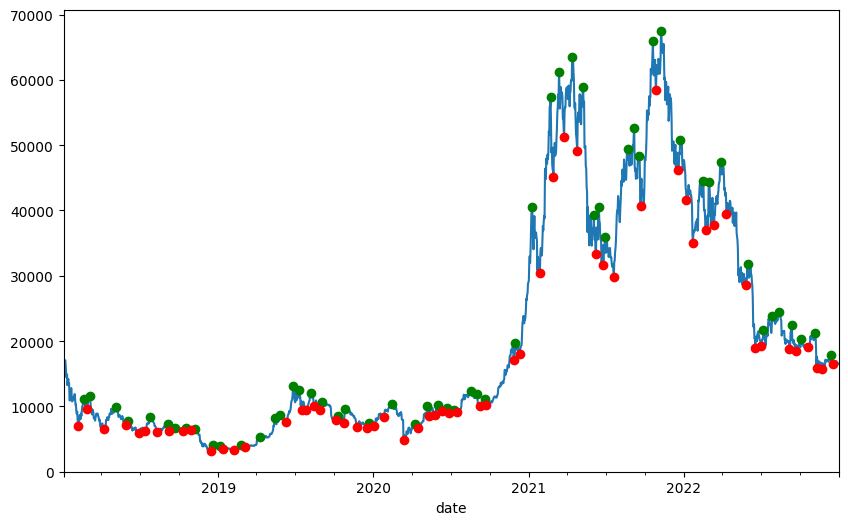

In [7]:
plt.figure(figsize=(10, 6))
data['close'].plot()
idx = data.index
for top in tops:
    plt.plot(idx[top[1]], top[2], marker='o', color='green')

for bottom in bottoms:
    plt.plot(idx[bottom[1]], bottom[2], marker='o', color='red')

plt.show()

In [8]:
# Scipy implementation (faster but use with care to not cheat with future data)
#import scipy
#arr = data['close'].to_numpy()
#bottoms = scipy.signal.argrelextrema(arr, np.less, order=3)
#tops = scipy.signal.argrelextrema(arr, np.greater, order=3)

## 2. Directional Change

In [9]:
def directional_change(close: np.array, high: np.array, low: np.array, sigma: float):
    
    up_zig = True # Last extreme is a bottom. Next is a top. 
    tmp_max = high[0]
    tmp_min = low[0]
    tmp_max_i = 0
    tmp_min_i = 0

    tops = []
    bottoms = []

    for i in range(len(close)):
        if up_zig: # Last extreme is a bottom
            if high[i] > tmp_max:
                # New high, update 
                tmp_max = high[i]
                tmp_max_i = i
            elif close[i] < tmp_max - tmp_max * sigma: 
                # Price retraced by sigma %. Top confirmed, record it
                # top[0] = confirmation index
                # top[1] = index of top
                # top[2] = price of top
                top = [i, tmp_max_i, tmp_max]
                tops.append(top)

                # Setup for next bottom
                up_zig = False
                tmp_min = low[i]
                tmp_min_i = i
        else: # Last extreme is a top
            if low[i] < tmp_min:
                # New low, update 
                tmp_min = low[i]
                tmp_min_i = i
            elif close[i] > tmp_min + tmp_min * sigma: 
                # Price retraced by sigma %. Bottom confirmed, record it
                # bottom[0] = confirmation index
                # bottom[1] = index of bottom
                # bottom[2] = price of bottom
                bottom = [i, tmp_min_i, tmp_min]
                bottoms.append(bottom)

                # Setup for next top
                up_zig = True
                tmp_max = high[i]
                tmp_max_i = i

    return tops, bottoms

In [10]:
def get_extremes(ohlc: pd.DataFrame, sigma: float):
    tops, bottoms = directional_change(ohlc['close'], ohlc['high'], ohlc['low'], sigma)
    tops = pd.DataFrame(tops, columns=['conf_i', 'ext_i', 'ext_p'])
    bottoms = pd.DataFrame(bottoms, columns=['conf_i', 'ext_i', 'ext_p'])
    tops['type'] = 1
    bottoms['type'] = -1
    extremes = pd.concat([tops, bottoms])
    extremes = extremes.set_index('conf_i')
    extremes = extremes.sort_index()
    return extremes

In [11]:
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [12]:
%%time

tops, bottoms = directional_change(data['close'].to_numpy(), data['high'].to_numpy(), data['low'].to_numpy(), 0.02)

CPU times: user 24.7 ms, sys: 439 µs, total: 25.2 ms
Wall time: 7.88 ms


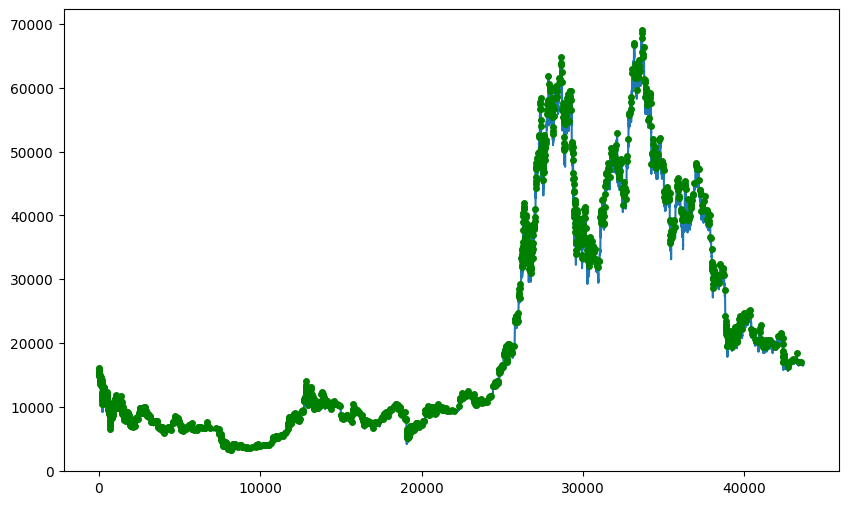

In [13]:
plt.figure(figsize=(10, 6))
pd.Series(data['close'].to_numpy()).plot()
idx = data.index
for top in tops:
    plt.plot(top[1], top[2], marker='o', color='green', markersize=4)

# for bottom in bottoms:
#     plt.plot(bottom[1], bottom[2], marker='o', color='red', markersize=4)

plt.show()

## 3. Perceptually Important Points

In [14]:
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    # dist_measure
    # 1 = Euclidean Distance
    # 2 = Perpindicular Distance
    # 3 = Vertical Distance

    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):

        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1

        for k in range(0, curr_point - 1):

            # Left adjacent, right adjacent indices
            left_adj = k
            right_adj = k + 1

            time_diff = pips_x[right_adj] - pips_x[left_adj]
            price_diff = pips_y[right_adj] - pips_y[left_adj]
            slope = price_diff / time_diff
            intercept = pips_y[left_adj] - pips_x[left_adj] * slope;

            for i in range(pips_x[left_adj] + 1, pips_x[right_adj]):
                
                d = 0.0 # Distance
                if dist_measure == 1: # Euclidean distance
                    d =  ( (pips_x[left_adj] - i) ** 2 + (pips_y[left_adj] - data[i]) ** 2 ) ** 0.5
                    d += ( (pips_x[right_adj] - i) ** 2 + (pips_y[right_adj] - data[i]) ** 2 ) ** 0.5
                elif dist_measure == 2: # Perpindicular distance
                    d = abs( (slope * i + intercept) - data[i] ) / (slope ** 2 + 1) ** 0.5
                else: # Vertical distance    
                    d = abs( (slope * i + intercept) - data[i] )

                if d > md:
                    md = d
                    md_i = i
                    insert_index = right_adj

        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])

    return pips_x, pips_y

In [15]:
data = pd.read_csv('src/BTCUSDT86400.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [16]:
i = 1198
x = data['close'].iloc[i-40:i].to_numpy()
pips_x, pips_y = find_pips(x, 5, 2)

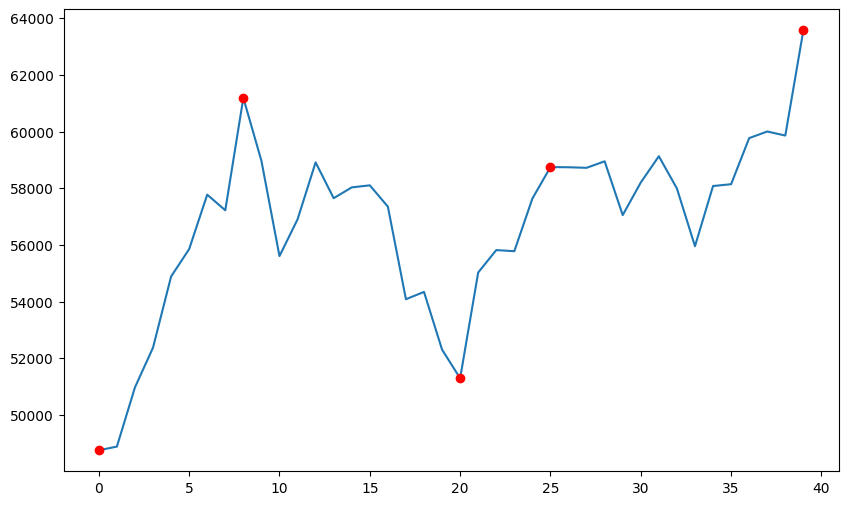

In [17]:
plt.figure(figsize=(10, 6))
pd.Series(x).plot()
for i in range(5):
    plt.plot(pips_x[i], pips_y[i], marker='o', color='red')

plt.show()